In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
import missingno as msno
import plotly.express as px # plotting geo data
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.feature_selection import mutual_info_regression
from sklearn.decomposition import PCA
import autofeat
import osmnx as ox
import geopandas as gpd
from tqdm import tqdm

from Own_imputers import PriorityGroupImputer
from OwnFeatEng import feature_engineering, feature_selection, add_geo_features
from OwnDimRed import PCA_num
from PrepData import preprocess

# Train

## Data

In [3]:
type_map = {
    'energy_label': 'category',
    'postcode': 'category',
    'advertiser' : 'category',
    'province' : 'category', 
    'house_type' : 'category',
    'subtype' : 'category',
    'new_building': 'bool'
}

In [ ]:
data = pd.read_csv("train.csv", header=0)
data = data.drop(columns=['is_promoted','sticker','price_drop_date'])
testdata = pd.read_csv("test.csv", header=0)
testdata = testdata.drop(columns=['is_promoted','sticker','price_drop_date'])

X_data, y_data = data.drop(columns='price'), data['price']
# fulldata = pd.concat([X_data,testdata]).reset_index(drop=True)

fullgeofeatures_train = pd.read_parquet('fullgeofeatures.parquet').iloc[:X_data.shape[0]]
geofeatcols = fullgeofeatures_train.columns.to_list()
fullgeofeatures_test = pd.read_parquet('fullgeofeatures.parquet').iloc[X_data.shape[0]:]


X_data = pd.concat([X_data, fullgeofeatures_train], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,test_size=0.2, shuffle=True, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, shuffle=True, test_size=0.2, random_state=42)

In [ ]:
prep = preprocess(type_map=type_map)
X_train = prep.train(X_train).reset_index(drop=True)
X_val = prep.test(X_val).reset_index(drop=True)

# fulldata = prep.train(fulldata).reset_index(drop=True)

In [ ]:
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()

# le = LabelEncoder()
# X_train['house_type'] = le.fit_transform(X_train['house_type'])  
# X_val['house_type'] = le.transform(X_val['house_type'])  

## Feature engineering

### loading geodata

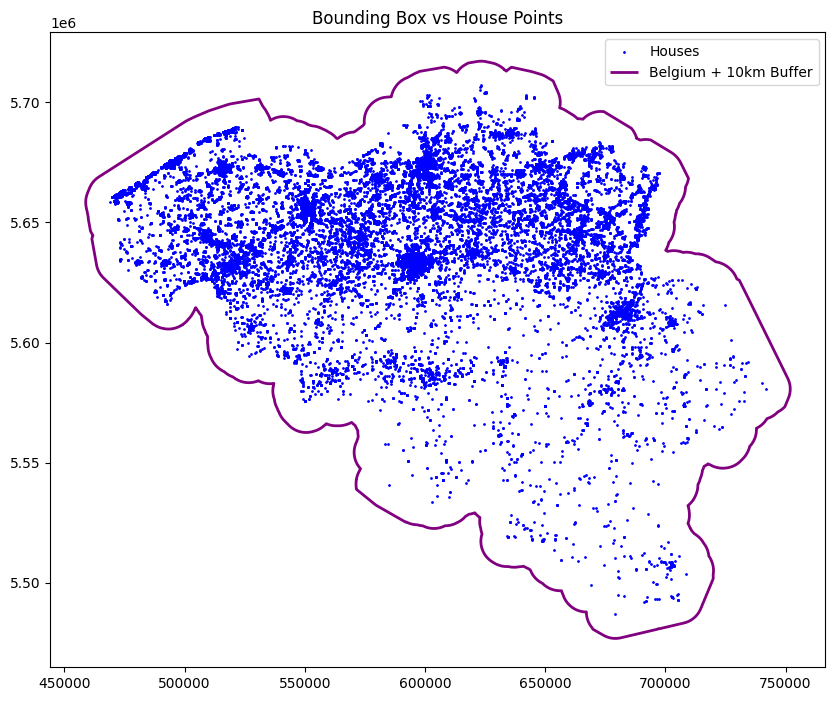

In [ ]:
# import osmnx as ox
# import matplotlib.pyplot as plt
# import geopandas as gpd
# from shapely.geometry import Point, box



# # Step 1: Convert to GeoDataFrame
# gdf_houses = gpd.GeoDataFrame(
#     fulldata,
#     geometry=[Point(xy) for xy in zip(fulldata['lon'], fulldata['lat'])],
#     crs="EPSG:4326"
# )

# # Step 2: Project to UTM
# utm_crs = gdf_houses.estimate_utm_crs()
# gdf_houses = gdf_houses.to_crs(utm_crs)

# # Step 3: Define bounding box with buffer

# intersection_gdf = gpd.read_file('intersection_gdf_espg4326.gpkg').to_crs(utm_crs)

# # Step 5: Plot
# fig, ax = plt.subplots(figsize=(10, 10))
# gdf_houses.plot(ax=ax, color='blue', markersize=1, label='Houses')

# intersection_gdf.boundary.plot(
#     ax=ax, color='purple', linewidth=2, label='Belgium + 10km Buffer'
# )
# plt.legend()
# plt.title("Bounding Box vs House Points")
# plt.show()

# intersection_gdf_espg4326 = intersection_gdf.to_crs("EPSG:4326").geometry.iloc[0]

In [ ]:
useamenity = ["restaurant", "fast_food", "cafe", "bar", "pub", 'nightclub' ,'stripclub', 'internet_cafe',
                "college", 'kindergarten', 'library', 'research_institute', 'music_school' , 'school', 'university', 'driving_school', 'traffic_park', 'driver_training',
                'bus_station', 'taxi',
                'bank',
                'clinic', 'dentist ' ,'doctors','hospital','nursing_home', 'pharmacy', 'social_facility', 'veterinary',
                'arts_centre','brothel','casino','cinema','community_centre','conference_centre','events_venue','exhibition_centre','fountain','gambling','music_venue',
                'planetarium','social_centre', 'stage', 'theatre',
                'courthouse', 'fire_station' ,'police', 'prison', 'townhall',
                'crematorium','funeral_hall','grave_yard','mortuary',
                'charging_station', 'fuel']
# area_calc = []
# tag_amenity = {'amenity': True}
# tag_shop = {'shop': True}
# tag_leisure = {'leisure': True}
# tag_tourism = {'tourism': True}
# tag_landuse = {'landuse': True}
# tag_natural = {'natural': True}

# tag_office = {'office': True}
# tag_healthcare = {'healthcare': True}

In [ ]:
# gdf_healthcare= ox.features.features_from_polygon(intersection_gdf_espg4326, tags=tag_healthcare) #[['geometry','office']]
# gdf_healthcare[['geometry','healthcare']].to_file("gdf_healthcare.gpkg", driver="GPKG")
# print(gdf_healthcare.head())

c:\Users\iskan\AppData\Local\Programs\Python\Python312\Lib\site-packages\osmnx\_overpass.py:267: UserWarning: This area is 17 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)
2025-05-05 23:27:56,453 INFO: Created 8,588 records


                                   geometry   amenity dispensing healthcare  \
element id                                                                    
node    27269823   POINT (4.34723 50.83132)  pharmacy        yes   pharmacy   
        76051405   POINT (6.09533 50.76844)  pharmacy        yes   pharmacy   
        96032016   POINT (3.42133 50.99812)  pharmacy        NaN   pharmacy   
        192578075  POINT (4.35551 50.85284)  pharmacy        yes   pharmacy   
        231403522   POINT (4.35221 50.8322)  pharmacy        yes   pharmacy   

                                  name                    website addr:city  \
element id                                                                    
node    27269823              Victoire                        NaN       NaN   
        76051405   Kurbrunnen Apotheke                        NaN    Aachen   
        96032016              Vandaele  http://www.apovandaele.be       NaN   
        192578075              Deroisy             

In [ ]:
# fig, ax = plt.subplots(figsize=(10, 10))
# gdf_tourism.plot(
#     ax=ax, color='purple', markersize=1
# )
# gdf_houses.to_crs(gdf_tourism.crs).plot(ax=ax, color='blue', markersize=1, label='Houses')
# plt.show()

In [ ]:
# valid_in_any_group = (
#     gdf_landuse.groupby('amenity')
#     .apply(lambda g: ~g.isna().any(), include_groups=False) 
#     .any(axis=0)                       
# )

### features from geodata


In [ ]:
# # X_try  = X_train.iloc[:3000]
# gdf_houses_espg4326 = gpd.GeoDataFrame(
#     fulldata,
#     geometry=[Point(xy) for xy in zip(fulldata['lon'], fulldata['lat'])],
#     crs="EPSG:4326"
# )

In [ ]:
gdf_shop = gpd.read_file('gdf_shop.gpkg')
shop_features = gdf_shop.groupby('shop')['geometry'].count()[(gdf_shop.groupby('shop')['geometry'].count()>10)]
# print(shop_features)

gdf_tourism = gpd.read_file('gdf_tourism.gpkg')
tourism_features = gdf_tourism.groupby('tourism')['geometry'].count()[(gdf_tourism.groupby('tourism')['geometry'].count()>10)]
# print(tourism_features)

gdf_natural = gpd.read_file('gdf_natural.gpkg')
natural_features = gdf_natural.groupby('natural')['geometry'].count()[(gdf_natural.groupby('natural')['geometry'].count()>10)]
# print(natural_features)

gdf_landuse = gpd.read_file('gdf_landuse.gpkg')
landuse_features = gdf_landuse.groupby('landuse')['geometry'].count()[(gdf_landuse.groupby('landuse')['geometry'].count()>10)]
# print(landuse_features)

gdf_amenity = gpd.read_file('gdf_amenity.gpkg')
amenity_features = gdf_amenity.groupby('amenity')['geometry'].count()[(gdf_amenity.groupby('amenity')['geometry'].count()>10)]
# print(amenity_features)

gdf_leisure = gpd.read_file('gdf_leisure.gpkg')
leisure_features = gdf_leisure.groupby('leisure')['geometry'].count()[(gdf_leisure.groupby('leisure')['geometry'].count()>10)]
# print(leisure_features)


gdf_office = gpd.read_file('gdf_office.gpkg')
office_features = gdf_office.groupby('office')['geometry'].count()[(gdf_office.groupby('office')['geometry'].count()>10)]
# print(leisure_features)


gdf_healthcare = gpd.read_file('gdf_healthcare.gpkg')
healthcare_features = gdf_healthcare.groupby('healthcare')['geometry'].count()[(gdf_healthcare.groupby('healthcare')['geometry'].count()>10)]
# print(leisure_features)

In [ ]:
# tagfeat_dict = {
                # 'amenity': gdf_amenity,
                # 'leisure': gdf_leisure,
                # 'shop': gdf_shop,
                # 'tourism': gdf_tourism,
                # 'natural': gdf_natural,
                # 'landuse': gdf_landuse,
                # 'office' : gdf_office,
                # 'healthcare' : gdf_healthcare
# } 

In [ ]:
# for tag in tqdm(tagfeat_dict.keys(), desc="Processing tags"):
#     feature_types = tagfeat_dict[tag].groupby(tag)['geometry'].count()[(tagfeat_dict[tag].groupby(tag)['geometry'].count()>10)].index.to_list()
#     for feature_type in tqdm(feature_types, desc=f"Features for {tag}"):
#         add_geo_features(gdf_houses_espg4326, tagfeat_dict[tag], tag, feature_type, [150, 300, 500, 1000, 1500, 2000], 10000, True).to_parquet(f'geofeatures/{tag}_{feature_type}.parquet')

Tree is created
Indexing is finished
Nearby geom created
distances created
areas created
Result df is created


Tree is created
Indexing is finished
Nearby geom created
distances created
areas created
Result df is created


Tree is created
Indexing is finished
Nearby geom created
distances created
areas created
Result df is created


Tree is created
Indexing is finished
Nearby geom created
distances created
areas created
Result df is created


Tree is created
Indexing is finished
Nearby geom created
distances created
areas created
Result df is created


Tree is created
Indexing is finished
Nearby geom created
distances created
areas created
Result df is created


Tree is created
Indexing is finished
Nearby geom created
distances created
areas created
Result df is created


Tree is created
Indexing is finished
Nearby geom created
distances created
areas created
Result df is created


Tree is created
Indexing is finished
Nearby geom created
distances created
areas created
Result df is created


Tree is created
Indexing is finished
Nearby geom created
distances created
areas created
Result df is created


Tree is created
Indexing is finished
Nearby geom created
distances created
areas created
Result df is created


Tree is created
Indexing is finished
Nearby geom created
distances created
areas created
Result df is created


Tree is created
Indexing is finished
Nearby geom created
distances created
areas created
Result df is created


Tree is created
Indexing is finished
Nearby geom created
distances created
areas created
Result df is created


Tree is created
Indexing is finished
Nearby geom created
distances created
areas created
Result df is created


Tree is created
Indexing is finished
Nearby geom created
distances created
areas created
Result df is created


Tree is created
Indexing is finished
Nearby geom created
distances created
areas created
Result df is created


Tree is created
Indexing is finished
Nearby geom created
distances created
areas created
Result df is created


Processing tags:  50%|█████     | 1/2 [03:39<03:39, 219.73s/it]

Tree is created
Indexing is finished
Nearby geom created
distances created
areas created
Result df is created


Tree is created
Indexing is finished
Nearby geom created
distances created
areas created
Result df is created


Tree is created
Indexing is finished
Nearby geom created
distances created
areas created
Result df is created


Tree is created
Indexing is finished
Nearby geom created
distances created
areas created
Result df is created


Tree is created
Indexing is finished
Nearby geom created
distances created
areas created
Result df is created


Tree is created
Indexing is finished
Nearby geom created
distances created
areas created
Result df is created


Tree is created
Indexing is finished
Nearby geom created
distances created
areas created
Result df is created


Tree is created
Indexing is finished
Nearby geom created
distances created
areas created
Result df is created


Tree is created
Indexing is finished
Nearby geom created
distances created
areas created
Result df is created


Tree is created
Indexing is finished
Nearby geom created
distances created
areas created
Result df is created


Tree is created
Indexing is finished
Nearby geom created
distances created
areas created
Result df is created


Tree is created
Indexing is finished
Nearby geom created
distances created
areas created
Result df is created


Tree is created
Indexing is finished
Nearby geom created
distances created
areas created
Result df is created


Tree is created
Indexing is finished
Nearby geom created
distances created
areas created
Result df is created


Tree is created
Indexing is finished
Nearby geom created
distances created
areas created
Result df is created


Tree is created
Indexing is finished
Nearby geom created
distances created
areas created
Result df is created


Tree is created
Indexing is finished
Nearby geom created
distances created
areas created
Result df is created


Tree is created
Indexing is finished
Nearby geom created
distances created
areas created
Result df is created


Tree is created
Indexing is finished
Nearby geom created
distances created
areas created
Result df is created


Tree is created
Indexing is finished
Nearby geom created
distances created
areas created
Result df is created


Tree is created
Indexing is finished
Nearby geom created
distances created
areas created
Result df is created


Tree is created
Indexing is finished
Nearby geom created
distances created
areas created
Result df is created


Tree is created
Indexing is finished
Nearby geom created
distances created
areas created
Result df is created


Processing tags: 100%|██████████| 2/2 [05:27<00:00, 163.57s/it]


In [ ]:
# import os

# # Directory containing your GPKG files
# df_dir = 'geofeatures'

# # Read all GPKG files in the directory
# df_list = []
# for file in os.listdir(df_dir):
#     if file.endswith('.parquet'):
#         file_path = os.path.join(df_dir, file)
#         df = pd.read_parquet(file_path)
#         df_list.append(df)
# fullgeofeatures = pd.concat(df_list,axis=1)
# fullgeofeatures.to_parquet('fullgeofeatures.parquet')

In [ ]:
# geofeatcols = park_features.columns[park_features.columns.get_loc('geometry') + 1:].to_list()

### New own features

In [ ]:
# from OwnFeatEng import SpecialTransform

# new_cols = SpecialTransform(X_train).columns.to_list()
# X_train = X_train.join(SpecialTransform(X_train))
# X_val = X_val.join(SpecialTransform(X_val))

In [ ]:
# cl_range = list(range(20,101,20)) + list(range(150,301,50))
# feateng = feature_engineering(targets=['area', 'bedrooms','energy_value'],
#                               transform_type=['median'],
#                               comp_type=['diff'],
#                               groups=['province','house_type'],
#                               features=['lat','lon'],
#                               cl_name='clt',
#                               clustering=True, 
#                               cluster_range=cl_range)

# feateng_density = feature_engineering(targets=['area'],
#                               transform_type=['count'],
#                               comp_type=None,
#                               groups=['province','house_type'],
#                               features=['lat','lon'],
#                               cl_name='clt',
#                               clustering=False, 
#                               cluster_range=cl_range)

# X_train_new = feateng.train(X_train)
# X_val_new = feateng.test(X_val)


# X_train_new = feateng_density.train(X_train_new)
# X_val_new = feateng_density.test(X_val_new)

In [ ]:
# X_train_new.columns

In [ ]:
# features_new = X_train_new.columns.to_list()[24:]
# print(len(features_new))

### Feature selection on correlation

In [ ]:
# def getnum(df):
#     logic = (df.dtypes=='float64') | (df.dtypes=='float32') | (df.dtypes=='float16')
#     num_features = df.dtypes[logic].index.to_list()
#     other_features = df.dtypes[~logic].index.to_list()
#     return num_features, other_features

In [ ]:
# plt.figure(figsize=(8, 6))
# sns.heatmap(spearman_corr, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
# plt.title('Spearman Correlation Matrix')
# plt.show()

In [ ]:
# numcols, othcols = getnum(X_train_new)
# catcols = ['new_building',
#  'advertiser',
#  'subtype',
#  'house_type',
#  'area_miss',
#  'lat_miss',
#  'advertiser_miss',
#  'subtype_miss',
#  'energy_label_miss',
#  'clt20',
#  'clt40',
#  'clt60',
#  'clt80',
#  'clt100',
#  'clt150',
#  'clt200',
#  'clt250',
#  'clt300']

# numcols = numcols + (
# ['miss_tot',
#  'area-clt20-count',
#  'area-clt40-count',
#  'area-clt60-count',
#  'area-clt80-count',
#  'area-clt100-count',
#  'area-clt150-count',
#  'area-clt200-count',
#  'area-clt250-count',
#  'area-clt300-count',
#  'area-province-count',
#  'area-house_type-count' ])

In [ ]:
# only_cor = feature_selection()
# selected, _ = only_cor.select(X_train_new[numcols])

In [ ]:
# items_to_remove = {'index', 'id', 'is_appartment', 'added_time', 'postcode', 'energy_label', 'province', 'bedrooms_cat', 'lon_miss' ,'energy_value_miss'}
# othcols = [x for x in othcols if x not in items_to_remove]
# features_filt = catcols+selected

### MI scores

In [ ]:
# from OwnFeatEng import make_mi_scores, plot_mi_scores
# mi_scores = make_mi_scores(X_train_new_new[features_new],y_train.reset_index(drop=True))
# plot_mi_scores(mi_scores)

### Autofeat

In [ ]:
# X_train_new = X_train_new[catcols + numcols]
# X_val_new = X_val_new[catcols + numcols]

In [ ]:
# categorical_cols=['house_type', 'lat_miss',  'clt20', 'clt40', 'clt60', 'clt80', 'clt100', 'clt150', 'clt200', 'clt250', 'clt300']
# feateng_cols=['area', 'energy_value', 'bedrooms', 'foto_amount']

# autofeatures = autofeat.AutoFeatRegressor(feateng_cols=feateng_cols, featsel_runs=2)
# X_train_feat = autofeatures.fit_transform(X_train_new[feateng_cols], np.log(y_train.reset_index(drop=True))).drop(columns=feateng_cols)
# X_val_feat = autofeatures.transform(X_val_new[feateng_cols]).drop(columns=feateng_cols)

# X_train_new = X_train_new.join(X_train_feat)
# X_val_new = X_val_new.join(X_val_feat)

## Dimensionality Reduction

### PCA

In [ ]:
# pca_own = PCA_num(n_components=100)
# X_train_red = pca_own.fit_transform(X_train_new_new)

## Model

In [1]:
uselanduse = ['landuse*forest', 'landuse*industrial', 'landuse*farmland','landuse*residential', 'landuse*farmyard','landuse*cemetery', 'landuse*commercial',  'landuse*railway','landuse*landfill']


In [ ]:
top = 100

top = 100/top
shop_features_top = shop_features.sort_values(ascending=False).index.to_list()[:int(np.round(len(shop_features)/4,0))]
tourism_features_top = tourism_features.sort_values(ascending=False).index.to_list()[:int(np.round(len(tourism_features)/top,0))]
landuse_features_top = landuse_features.sort_values(ascending=False).index.to_list()[:int(np.round(len(landuse_features),0))]
natural_features_top = natural_features.sort_values(ascending=False).index.to_list()[:int(np.round(len(natural_features)/6,0))]
amenity_features_top = amenity_features.sort_values(ascending=False).index.to_list()[:int(np.round(len(amenity_features)/top,0))]
leisure_features_top = leisure_features.sort_values(ascending=False).index.to_list()[:int(np.round(len(leisure_features)/3,0))]
office_features_top = office_features.sort_values(ascending=False).index.to_list()[:int(np.round(len(office_features),0))]
healthcare_features_top = healthcare_features.sort_values(ascending=False).index.to_list()[:int(np.round(len(healthcare_features),0))]

shop_features_top = [f'shop*{entry}' for entry in shop_features_top]
tourism_features_top = [f'tourism*{entry}' for entry in tourism_features_top]
landuse_features_top = [f'landuse*{entry}' for entry in landuse_features_top]
natural_features_top = [f'natural*{entry}' for entry in natural_features_top]
amenity_features_top = [f'amenity*{entry}' for entry in amenity_features_top]
leisure_features_top = [f'leisure*{entry}' for entry in leisure_features_top]
office_features_top = [f'office*{entry}' for entry in office_features_top]
healthcare_features_top = [f'healthcare*{entry}' for entry in healthcare_features_top]


featlist_top = shop_features_top + tourism_features_top + uselanduse + natural_features_top + amenity_features_top + leisure_features_top + office_features_top + healthcare_features_top

filterfeats = ['median_', 'area_shop', 'area_tourism', 'count_landuse', 'area_amenity', ' area_office', 'area_healthcare']
geofeatcols_new = [entry for entry in geofeatcols if not any(w in entry for w in filterfeats)]
geofeatcols_new = [entry for entry in geofeatcols_new if any(w in entry for w in featlist_top)]

In [78]:
features_init = (['is_appartment',
 'area',
 'bedrooms',
 'new_building',
 'lat',
 'lon',
#  'advertiser',
 'foto_amount',
#  'subtype',
 'energy_value',
#  'province',
 'house_type',
 'area_miss',
 'lat_miss',
 'advertiser_miss',
#  'subtype_miss',
 'energy_value_miss'])

#X_train, X_val, y_train, y_val = train_test_split(train[features],train['price'], shuffle=False, test_size=0.2)
features_model = (features_init
                #+features_new
                +geofeatcols_new
)

In [79]:
len(features_model)

3472

### RandomForest


In [34]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_squared_error

In [35]:
# rf_reg = RandomForestRegressor(n_estimators=600, random_state=42, max_depth = 15, max_features=300)
# rf_reg.fit(X_train[features_model], y_train.reset_index(drop=True))

In [36]:
# y_pred = rf_reg.predict(X_val[features_model])
# RMSE_score = mean_squared_error(y_val.reset_index(drop=True), y_pred)**(1/2)
# print(RMSE_score)

### KNN

In [37]:
# X_train, y_train = train[['is_appartment','area','lat','lon','foto_amount','energy_value','house_type']].copy(),train['price'].copy()

# X_train_encoded = pd.get_dummies(X_train, columns=['house_type'])

# scaler = StandardScaler()
# X_train_encoded[['area','lat','lon','energy_value','foto_amount']] = scaler.fit_transform(X_train_encoded[['area','lat','lon','energy_value','foto_amount']])

In [38]:
# scores_KNN = []
# for i in range(2,60,2):
#     neigh_model = KNeighborsRegressor(n_neighbors=i, weights='distance')
#     scores_KNN.append(cross_val_score(neigh_model, X_train_encoded, y_train, cv=5, scoring='neg_mean_absolute_percentage_error')*-1)

# scores_KNN = pd.DataFrame(scores_KNN)
# plt.scatter((scores_KNN.index+1)*2, scores_KNN.apply(np.mean, axis=1))

In [39]:
# neigh_model_final = KNeighborsRegressor(n_neighbors=14, weights='distance')
# neigh_model_final.fit(X_train_encoded,y_train)

### XGBoost

In [80]:
dtrain = xgb.DMatrix(X_train[features_model], label=y_train.reset_index(drop=True), enable_categorical=True)
dval = xgb.DMatrix(X_val[features_model],label=y_val.reset_index(drop=True), enable_categorical=True)

evallist = [(dval, 'val')]
param_xgb = {'max_depth': 7, 'eta': 0.05, 'objective': 'reg:squarederror', 'reg_lambda':0, 'reg_alpha':0, 'eval_metric': 'rmse', }
evals_result = {}

xgb_regressor = xgb.train(
    params=param_xgb,
    dtrain=dtrain,
    num_boost_round=2000,
    evals=evallist,
    early_stopping_rounds=50,
    evals_result=evals_result,
    verbose_eval = True
)

# xgb_regressor = xgb.train(
#     params=param_xgb,
#     dtrain=dtrain,
#     num_boost_round=xgb_regressor.best_iteration + 1, 
#     evals=evallist
# )

# RMSE = np.mean((np.exp(xgb_regressor.predict(dval))-y_val)**2)**(1/2)
# print(RMSE)
# xgb_regressor.eval(dval)
baseline = np.min(evals_result['val']['rmse'])
print(baseline)

[0]	val-rmse:177026.12570
[1]	val-rmse:172760.08991
[2]	val-rmse:168703.10627
[3]	val-rmse:164932.09519
[4]	val-rmse:161455.45872
[5]	val-rmse:158046.08010
[6]	val-rmse:154871.78768
[7]	val-rmse:151853.35683
[8]	val-rmse:149069.23554
[9]	val-rmse:146479.83300
[10]	val-rmse:144166.70278
[11]	val-rmse:141987.90891
[12]	val-rmse:139767.23423
[13]	val-rmse:137664.01286
[14]	val-rmse:135923.75661
[15]	val-rmse:134221.48575
[16]	val-rmse:132631.39654
[17]	val-rmse:131079.66995
[18]	val-rmse:129620.11337
[19]	val-rmse:128314.51126
[20]	val-rmse:127096.27427
[21]	val-rmse:125941.87650
[22]	val-rmse:124863.39538
[23]	val-rmse:123770.79964
[24]	val-rmse:122737.98383
[25]	val-rmse:121693.99528
[26]	val-rmse:120899.14962
[27]	val-rmse:120026.68845
[28]	val-rmse:119146.49896
[29]	val-rmse:118363.10060
[30]	val-rmse:117719.76355
[31]	val-rmse:117078.05383
[32]	val-rmse:116372.27040
[33]	val-rmse:115836.98161
[34]	val-rmse:115328.17026
[35]	val-rmse:114793.53717
[36]	val-rmse:114267.26983
[37]	val-rm

In [75]:
# importance = pd.Series(xgb_regressor.get_score(importance_type='total_gain')).sort_values(ascending=False)
featsel = importance.index.to_list()[:200]

In [ ]:
baseline = np.min(evals_result['val']['rmse'])
featfinal= geofeatcols_new + features_init
for feat in tqdm(featlist_top):
    featlist_test = [entry for entry in featfinal if not any(w in entry for w in [feat])]
    evals_result_test = {}
    dtrain = xgb.DMatrix(X_train[featlist_test], label=y_train.reset_index(drop=True), enable_categorical=False)
    dval = xgb.DMatrix(X_val[featlist_test],label=y_val.reset_index(drop=True), enable_categorical=False)
    evallist = [(dval, 'val')]
    xgb_regressor = xgb.train(
        params=param_xgb,
        dtrain=dtrain,
        num_boost_round=2000,
        evals=evallist,
        early_stopping_rounds=50,
        evals_result=evals_result_test,
        verbose_eval = False
    )
    result_test = np.min(evals_result_test['val']['rmse'])
    print(result_test)
    if result_test<=baseline:
        xgb_selected = xgb_regressor
        featfinal = featlist_test
        baseline = result_test
        print('New baseline established')

  0%|          | 1/472 [07:01<55:07:54, 421.39s/it]

100626.16712026956


  0%|          | 1/472 [10:04<79:05:21, 604.50s/it]


KeyboardInterrupt: 

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

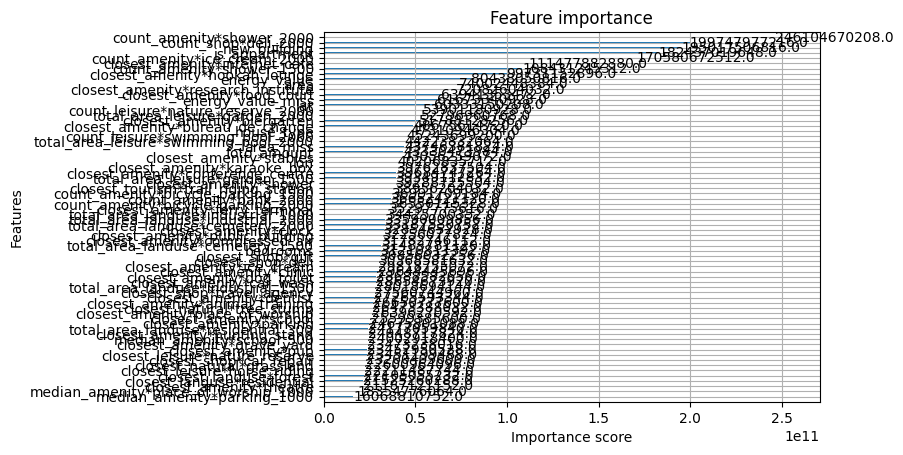

In [60]:
xgb.plot_importance(xgb_regressor, importance_type='gain')

# Test

## Data

## KNN

In [ ]:
# X_test = test[['is_appartment','area','lat','lon','foto_amount','energy_value','house_type']].copy()

# X_test_encoded = pd.get_dummies(X_test, columns=['house_type'])

# scaler = StandardScaler()
# X_test_encoded[['area','lat','lon','energy_value','foto_amount']] = scaler.fit_transform(X_test_encoded[['area','lat','lon','energy_value','foto_amount']])
# X_test_encoded.isna().apply(sum)
# y_test = test['price'].copy()
# y_pred_test = neigh_model_final.predict(X_test_encoded)

## XGBoost

## Error bars

In [615]:
mean_error_1=(y_pred_test/y_test-1).mean()
error_bound_1 = (y_pred_test/y_test-1).std()/len(y_pred_test)**(1/2)*1.96

mean_error_2=abs(y_pred_test/y_test-1).mean()
error_bound_2 = abs(y_pred_test/y_test-1).std()/(len(y_pred_test)**(1/2))*1.96

mean_error_3=((y_pred_test-y_test)**2).mean()**(1/2)
error_bound_3 = abs(y_pred_test-y_test).std()/(len(y_pred_test)**(1/2))*1.96

# Submission metrics

In [510]:
y_pred_final = pd.DataFrame()
y_pred_final['id']=test['id']
y_pred_final['lower']=y_pred_test*(1-mean_error_1-error_bound_1)
y_pred_final['upper']=y_pred_test*(1-mean_error_1+error_bound_1)
y_pred_final['pred']=y_pred_test*(1-mean_error_1)

y_pred_final.to_csv(f"xgb_simple_1.csv", index=False)

In [513]:
y_pred_final = pd.DataFrame()
y_pred_final['id']=test['id']
y_pred_final['lower']=y_pred_test*(1-mean_error_2-error_bound_2)
y_pred_final['upper']=y_pred_test*(1+mean_error_2+error_bound_2)
y_pred_final['pred']=y_pred_test

y_pred_final.to_csv(f"xgb_simple_2.csv", index=False)

In [512]:
y_pred_final = pd.DataFrame()
y_pred_final['id']=test['id']
y_pred_final['lower']=np.maximum(y_pred_test-mean_error_3-error_bound_3,0)
y_pred_final['upper']=y_pred_test+mean_error_3+error_bound_3
y_pred_final['pred']=y_pred_test

y_pred_final.to_csv(f"xgb_simple_3.csv", index=False)